In [118]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

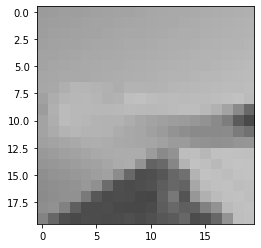

In [122]:
img = Image.fromarray(np.array(Image.open('desert.jpg')))
img = img.resize((100,100))
img_grayscale = np.asarray(ImageOps.grayscale(img))
img_grayscale = img_grayscale[30:50,25:45]
[height, width] = img_grayscale.shape
plt.imshow(img_grayscale,  cmap='gray', vmin=0, vmax=255)

In [32]:
dim = img_grayscale.shape[0] * img_grayscale.shape[1]
weights = np.zeros([dim, dim])
weights.shape

(400, 400)

In [33]:
DIST_PARAM = 10
sigma_squared_i = 400
sigma_squared_x = 50

for i in range(weights.shape[0]):
    i_row, i_col = i // img_grayscale.shape[0], i % img_grayscale.shape[1]
    for row_offset in range(-min(DIST_PARAM, i_row), min(DIST_PARAM + 1, img_grayscale.shape[0] - i_row)):
        j_row = i_row + row_offset
        for col_offset in range(-min(DIST_PARAM, i_col), min(DIST_PARAM + 1, img_grayscale.shape[1] - i_col)):
            j_col = i_col + col_offset
            dist = abs(row_offset) + abs(col_offset)
            if dist > 2*DIST_PARAM:
                print("ERROR")
                print(dist)
            j = j_row * img_grayscale.shape[1] + j_col
            intensity_exp = ((img_grayscale[j_row, j_col] - img_grayscale[i_row, i_col])**2)/sigma_squared_i
            distance_exp = dist**2/sigma_squared_x
            weights[i][j] = np.exp(-intensity_exp - distance_exp)

/var/folders/y6/dcvw5tyn609_4w5cdgrwktw00000gp/T/ipykernel_66085/2112187857.py:16: RuntimeWarning: overflow encountered in ulong_scalars
  intensity_exp = ((img_grayscale[j_row, j_col] - img_grayscale[i_row, i_col])**2)/sigma_squared_i


In [34]:
weights.shape

(400, 400)

In [35]:
import cvxpy as cvx

X = cvx.Variable((dim, dim), PSD=True)
obj = cvx.sum(cvx.multiply(weights, X))
constr = [cvx.diag(X) == 1, cvx.sum(X) <= 0.15*dim*dim]
problem = cvx.Problem(cvx.Maximize(obj), constraints=constr)
problem.solve(solver=cvx.SCS, verbose=True)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 10 06:18:14 PM: Your problem has 160000 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 10 06:18:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 10 06:18:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 10 06:18:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 10 06:18:14 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 10 06:18:14 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> C

4951.567909425034

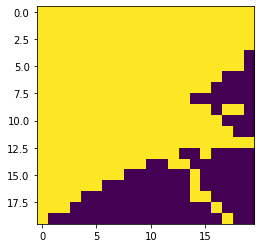

In [185]:
import math

# recover the original vectors
sol = X.value
S, eig, S_T = np.linalg.svd(X.value)
V = np.transpose(S * np.sqrt(eig))  

# do the random hyperplane rounding
random_hyperplane_rounding = np.random.randn(dim)
# rearrange the cut to form an image again
cut = np.sign(random_hyperplane_rounding @ V).reshape(int(math.sqrt(dim)), int(math.sqrt(dim)), order = 'C')
#display the image
plt.imshow((cut+1)*125)